<a href="https://colab.research.google.com/github/Muthon1/DataScience/blob/main/Machine_Learning_Project_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Load the dataset
df = pd.read_csv('/content/bangladesh_divisions_dataset.csv')

In [35]:
df.head()

,Location,Soil_Type,Fertility_Index,Land_Use_Type,Average_Rainfall(mm),Temperature(°C),Crop_Suitability,Season,Satellite_Observation_Date,Remarks
0,Sylhet,Loamy,62,Agricultural,72,28.6,Wheat,Monsoon,2024-09-24,Requires attention
1,Dhaka,Sandy,63,Unused,118,23.8,Maize,Autumn,2024-01-31,Moderate potential
2,Rangpur,Peaty,51,Agricultural,106,32.0,Maize,Autumn,2024-03-11,Requires attention
3,Khulna,Sandy,67,Barren,336,31.6,Wheat,Autumn,2024-09-29,Low potential
4,Rangpur,Peaty,63,Agricultural,237,20.1,Rice,Winter,2024-04-01,Moderate potential


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Location                    2000 non-null   object 
 1   Soil_Type                   2000 non-null   object 
 2   Fertility_Index             2000 non-null   int64  
 3   Land_Use_Type               2000 non-null   object 
 4   Average_Rainfall(mm)        2000 non-null   int64  
 5   Temperature(°C)             2000 non-null   float64
 6   Crop_Suitability            2000 non-null   object 
 7   Season                      2000 non-null   object 
 8   Satellite_Observation_Date  2000 non-null   object 
 9   Remarks                     2000 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 156.4+ KB


In [37]:
df.describe()

,Fertility_Index,Average_Rainfall(mm),Temperature(°C)
count,2000.00000,2000.000000,2000.000000
mean,70.10450,223.136000,27.330250
std,17.97699,100.548543,4.341251
min,40.00000,50.000000,20.000000
25%,54.00000,137.000000,23.500000
50%,70.00000,222.500000,27.300000
75%,86.00000,308.000000,31.000000
max,100.00000,400.000000,35.000000


In [38]:
# Check for missing values
df.isnull().sum()

,0
Location,0
Soil_Type,0
Fertility_Index,0
Land_Use_Type,0
Average_Rainfall(mm),0
Temperature(°C),0
Crop_Suitability,0
Season,0
Satellite_Observation_Date,0
Remarks,0


In [39]:
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Apply Standard Scaler to numerical features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['Fertility_Index', 'Average_Rainfall(mm)', 'Temperature(°C)']] = scaler.fit_transform(df[['Fertility_Index', 'Average_Rainfall(mm)', 'Temperature(°C)']])

# Alternatively, use MinMaxScaler if scaling to a [0, 1] range
min_max_scaler = MinMaxScaler()
df_minmax = df.copy()
# Use double brackets to select multiple columns for MinMaxScaler
df_minmax[['Fertility_Index', 'Average_Rainfall(mm)', 'Temperature(°C)']] = min_max_scaler.fit_transform(df[['Fertility_Index', 'Average_Rainfall(mm)', 'Temperature(°C)']])

In [40]:
# Feature engineering
# Creating new features
df['Fertility_Index_Squared'] = df['Fertility_Index'] ** 2
df['Fertility_Index_Cubed'] = df['Fertility_Index'] ** 3

In [41]:
# Log Transformation of skewed features
df['Log_Average_Rainfall'] = np.log1p(df['Average_Rainfall(mm)'])
df['Log_Temperature'] = np.log1p(df['Temperature(°C)'])

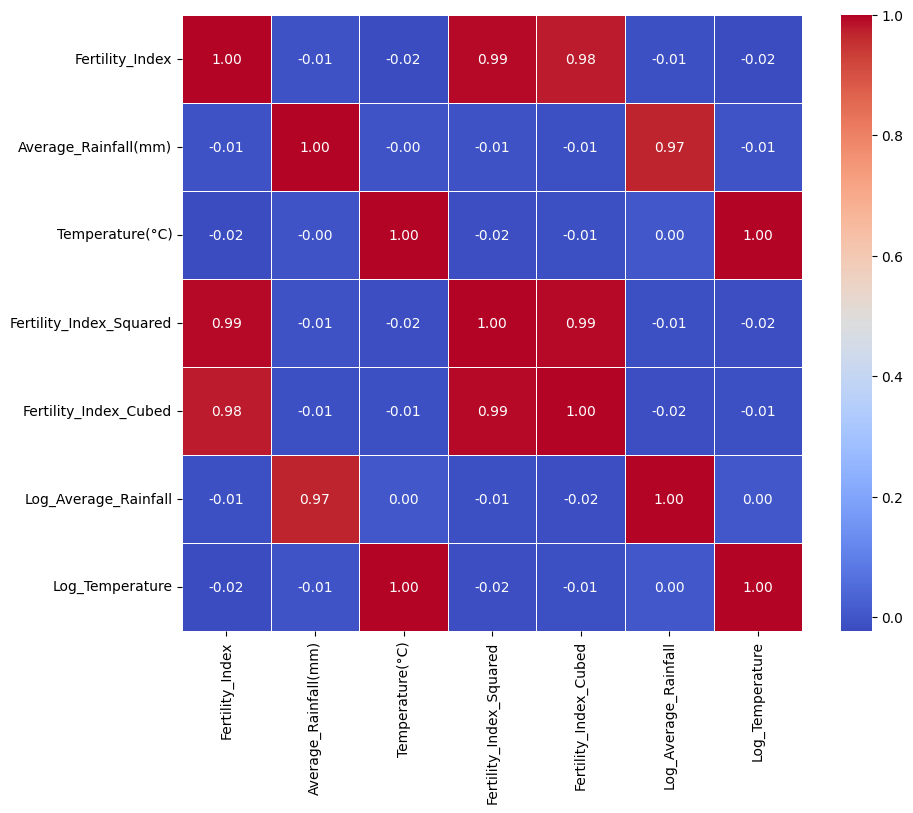

In [42]:
# Correlation matrix to identify highly correlated features
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [43]:
# Drop features with high multicollinearity
df.drop(columns=['Land_Use_Type', 'Location'], inplace=True)



In [47]:
# Recursive Feature Elimination (RFE) for feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Fit a Random Forest model and perform RFE
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=5)  # Choose top 5 features

# Create a copy of the DataFrame to avoid modifying the original
X_rfe = df.drop('Crop_Suitability', axis=1).copy()
y_rfe = df['Crop_Suitability'].copy() # Create a copy of the target variable

# Identify categorical and numerical features
categorical_features = ['Soil_Type', 'Season']  # Add 'Season' if it's categorical
numerical_features = X_rfe.select_dtypes(include=np.number).columns.tolist()

# Create transformers for categorical and numerical features
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for RFE
numerical_transformer = 'passthrough'  # No transformation for numerical features

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
X_rfe_encoded = preprocessor.fit_transform(X_rfe)

# Get feature names after transformation
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
X_rfe_encoded = pd.DataFrame(X_rfe_encoded, columns=feature_names)

# Encode the target variable 'Crop_Suitability'
label_encoder = LabelEncoder() # Initialize LabelEncoder
y_rfe_encoded = label_encoder.fit_transform(y_rfe) # Encode the target variable

# Now perform RFE with the encoded data
X_rfe_selected = rfe.fit_transform(X_rfe_encoded, y_rfe_encoded) # Use the encoded target variable

# Get selected feature names
selected_columns = [feature_names[i] for i in rfe.get_support(indices=True)] #Get selected feature names

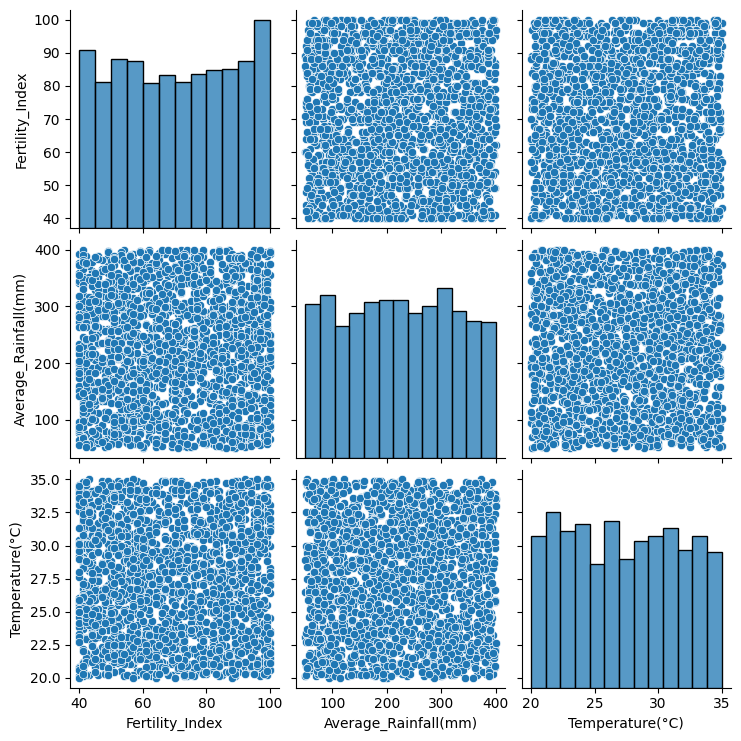

In [48]:
# Pair Plot to visualize relationships between features
sns.pairplot(df[['Fertility_Index', 'Average_Rainfall(mm)', 'Temperature(°C)', 'Crop_Suitability']])
plt.show()


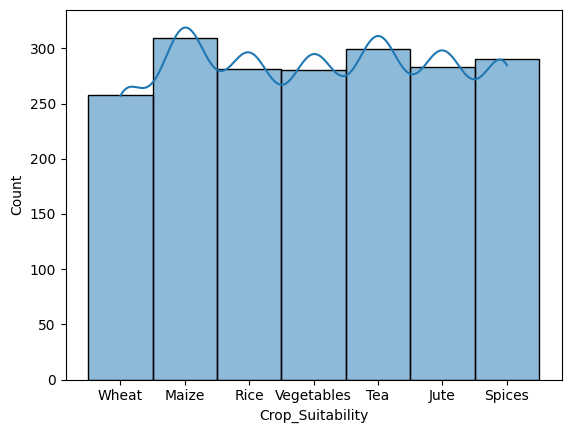

In [50]:
# Distribution of target variable
sns.histplot(df['Crop_Suitability'], kde=True)
plt.show()

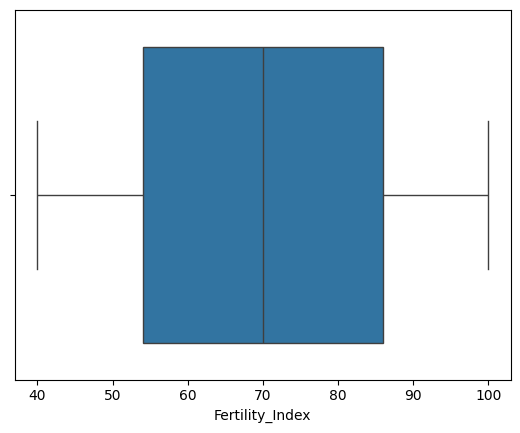

In [51]:
# Box plot to identify outliers
sns.boxplot(x=df['Fertility_Index'])
plt.show()

In [53]:
#model selection
from sklearn.model_selection import train_test_split

# Split dataset into features and target
X = df.drop('Crop_Suitability', axis=1)
y = df['Crop_Suitability']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
# model training
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, LabelEncoder # Import LabelEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(random_state=42)
svr = SVR()

# ---Data Preprocessing---
# Identify categorical and numerical features
categorical_features = ['Soil_Type', 'Season']
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

# Create transformers for categorical and numerical features
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for compatibility
numerical_transformer = 'passthrough'  # No transformation for numerical features

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)

# Get feature names after transformation
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Convert the encoded data back to a DataFrame for easier handling
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index) # Keep original index

# Transform the test data using the same preprocessor
X_test_encoded = preprocessor.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index) # Keep original index

# Encode the target variable
label_encoder = LabelEncoder() # Initialize LabelEncoder
y_train_encoded = label_encoder.fit_transform(y_train) # Encode y_train
y_test_encoded = label_encoder.transform(y_test) # Encode y_test using the same encoder


# Now train the models---
lr.fit(X_train_encoded, y_train_encoded) # Use the encoded target variable for training
rf.fit(X_train_encoded, y_train_encoded) # Use the encoded target variable for training
xgb.fit(X_train_encoded, y_train_encoded) # Use the encoded target variable for training
svr.fit(X_train_encoded, y_train_encoded) # Use the encoded target variable for training

SVR()

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions using the encoded test data (X_test_encoded)
y_pred_lr = lr.predict(X_test_encoded)  # Use X_test_encoded here
y_pred_rf = rf.predict(X_test_encoded)  # Use X_test_encoded here
y_pred_xgb = xgb.predict(X_test_encoded) # Use X_test_encoded here
y_pred_svr = svr.predict(X_test_encoded) # Use X_test_encoded here

In [61]:
# model training
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, LabelEncoder # Import LabelEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd


# Evaluate models
# Convert y_test to numerical using the same LabelEncoder used for training
y_test_encoded_for_eval = label_encoder.transform(y_test)

print("Linear Regression - MAE:", mean_absolute_error(y_test_encoded_for_eval, y_pred_lr))
print("Random Forest - MAE:", mean_absolute_error(y_test_encoded_for_eval, y_pred_rf))
print("XGBoost - MAE:", mean_absolute_error(y_test_encoded_for_eval, y_pred_xgb))
print("SVR - MAE:", mean_absolute_error(y_test_encoded_for_eval, y_pred_svr))

print("Linear Regression - R²:", r2_score(y_test_encoded_for_eval, y_pred_lr))
print("Random Forest - R²:", r2_score(y_test_encoded_for_eval, y_pred_rf))
print("XGBoost - R²:", r2_score(y_test_encoded_for_eval, y_pred_xgb))
print("SVR - R²:", r2_score(y_test_encoded_for_eval, y_pred_svr))

# RMSE (Root Mean Squared Error)
print("Linear Regression - RMSE:", np.sqrt(mean_squared_error(y_test_encoded_for_eval, y_pred_lr)))
print("Random Forest - RMSE:", np.sqrt(mean_squared_error(y_test_encoded_for_eval, y_pred_rf)))
print("XGBoost - RMSE:", np.sqrt(mean_squared_error(y_test_encoded_for_eval, y_pred_xgb)))
print("SVR - RMSE:", np.sqrt(mean_squared_error(y_test_encoded_for_eval, y_pred_svr)))

Linear Regression - MAE: 1.8264808087598459
Random Forest - MAE: 1.860475
XGBoost - MAE: 1.911586880683899
SVR - MAE: 1.814926900106542
Linear Regression - R²: -0.016049038328472154
Random Forest - R²: -0.0784888125752321
XGBoost - R²: -0.2427912950515747
SVR - R²: -0.006804054117941494
Linear Regression - RMSE: 2.074824852968053
Random Forest - RMSE: 2.137627013770176
XGBoost - RMSE: 2.2946858256262614
SVR - RMSE: 2.0653639139125834


In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Assuming categorical_features and numerical_features are already defined
categorical_features = ['Soil_Type', 'Season']
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

# Create transformers for categorical and numerical features
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
numerical_transformer = 'passthrough'

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)

# Get feature names after transformation
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Convert the encoded data back to a DataFrame for GridSearchCV
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names)

# Now use the encoded data for GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Encode the target variable before fitting GridSearchCV
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode y_train for GridSearchCV

grid_search_rf.fit(X_train_encoded, y_train_encoded) # Fit with encoded data and target


# Best parameters and score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Best score for Random Forest: -4.005404002731382


The goal of this project is to determine the most suitable model to use in making informed decisions, on which crops are best suited for a specific region while relying on historical data and obsevations.